# Task 1 Alignment

This notebook computes the target distributions and retrieved page alignments for **Task 1**.
It depends on the output of the PageAlignments notebook.

This notebook can be run in two modes: 'train', to process the training topics, and 'eval' for the eval topics.

In [1]:
DATA_MODE = 'train'

## Setup

We begin by loading necessary libraries:

In [5]:
import sys
import warnings
from collections import namedtuple
from functools import reduce
from itertools import product
import operator
from pathlib import Path

In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
from natural.size import binarysize
from natural.number import number

Set up progress bar and logging support:

In [7]:
from tqdm.auto import tqdm
tqdm.pandas(leave=False)

C:\Users\marta\anaconda3\envs\pyserini\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import sys, logging
logging.basicConfig(level=logging.INFO, stream=sys.stderr)
log = logging.getLogger('Task1Alignment')

And set up an output directory:

In [9]:
from wptrec.save import OutRepo
output = OutRepo('data/metric-tables')

## Data and Helpers

Most data loading is outsourced to `MetricInputs`.  First we save the data mode where metric inputs can find it:

In [10]:
import wptrec
wptrec.DATA_MODE = DATA_MODE

In [11]:
from MetricInputs import *

data/trec_2022_train_reldocs.jsonl


INFO:MetricInputs:reading data\metric-tables\page-sub-geo-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-src-geo-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-gender-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-occ-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-alpha-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-age-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-pop-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-langs-align.parquet


In [12]:
dimensions

[<dimension "sub-geo": 21 levels>,
 <dimension "src-geo": 21 levels>,
 <dimension "gender": 4 levels>,
 <dimension "occ": 33 levels>,
 <dimension "alpha": 4 levels>,
 <dimension "age": 4 levels>,
 <dimension "pop": 4 levels>,
 <dimension "langs": 3 levels>]

### qrel join

We want a function to join alignments with qrels:

In [13]:
def qr_join(align):
    return qrels.join(align, on='page_id').set_index(['topic_id', 'page_id'])

### norm_dist

And a function to normalize to a distribution:

In [14]:
def norm_dist_df(mat):
    sums = mat.sum('columns')
    return mat.divide(sums, 'rows')

## Prep Overview

Now that we have our alignments and qrels, we are ready to prepare the Task 1 metrics.

We're first going to prepare the target distributions; then we will compute the alignments for the retrieved pages.

## Subject Geography

Subject geography targets the average of the relevant set alignments and the world population.

In [15]:
qr_sub_geo_align = qr_join(sub_geo_align)
qr_sub_geo_align

@UNKNOWN  Antarctica  Caribbean  Central America  \
topic_id page_id                                                      
84       572            1.0         0.0        0.0              0.0   
         627            1.0         0.0        0.0              0.0   
         678            1.0         0.0        0.0              0.0   
         903            1.0         0.0        0.0              0.0   
         1193           1.0         0.0        0.0              0.0   
...                     ...         ...        ...              ...   
2859     69878035       0.0         0.0        0.0              0.0   
         69879576       0.0         0.0        0.0              0.0   
         69882349       1.0         0.0        0.0              0.0   
         69887896       1.0         0.0        0.0              0.0   
         69891491       0.0         0.0        0.0              0.0   

                   Central Asia  Eastern Africa  Eastern Asia  Eastern Europe  \
topic_id page_id                                                                
84       572                0.0             0.0           0.0             0.0   
         627                0.0             0.0           0.0             0.0   
         678                0.0             0.0           0.0             0.0   
         903                0.0             0.0           0.0             0.0   
         1193               0.0             0.0           0.0             0.0   
...                         ...             ...           ...             ...   
2859     69878035           0.0             0.0           0.0             1.0   
         69879576           0.0             0.0           0.0             0.0   
         69882349           0.0             0.0           0.0             0.0   
         69887896           0.0             0.0           0.0             0.0   
         69891491           0.0             0.0           0.0             0.0   

                   Middle Africa  Northern Africa  ...  Northern Europe  \
topic_id page_id                                   ...                    
84       572                 0.0              0.0  ...              0.0   
         627                 0.0              0.0  ...              0.0   
         678                 0.0              0.0  ...              0.0   
         903                 0.0              0.0  ...              0.0   
         1193                0.0              0.0  ...              0.0   
...                          ...              ...  ...              ...   
2859     69878035            0.0              0.0  ...              0.0   
         69879576            0.0              0.0  ...              0.0   
         69882349            0.0              0.0  ...              0.0   
         69887896            0.0              0.0  ...              0.0   
         69891491            0.0              0.0  ...              0.0   

                   Oceania  South America  South-eastern Asia  \
topic_id page_id                                                
84       572           0.0            0.0                 0.0   
         627           0.0            0.0                 0.0   
         678           0.0            0.0                 0.0   
         903           0.0            0.0                 0.0   
         1193          0.0            0.0                 0.0   
...                    ...            ...                 ...   
2859     69878035      0.0            0.0                 0.0   
         69879576      0.0            0.0                 0.0   
         69882349      0.0            0.0                 0.0   
         69887896      0.0            0.0                 0.0   
         69891491      0.0            0.0                 0.0   

                   Southern Africa  Southern Asia  Southern Europe  \
topic_id page_id                                                     
84       572                   0.0            0.0              0.0   
         

For purely geographic fairness, we just need to average the unknowns with the world pop:

In [16]:
qr_sub_geo_tgt = qr_sub_geo_align.groupby('topic_id').mean()
qr_sub_geo_fk = qr_sub_geo_tgt.iloc[:, 1:].sum('columns')
qr_sub_geo_tgt.iloc[:, 1:] *= 0.5
qr_sub_geo_tgt.iloc[:, 1:] += qr_sub_geo_fk.apply(lambda k: world_pop * k * 0.5)
qr_sub_geo_tgt.head()

,@UNKNOWN,Antarctica,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Middle Africa,Northern Africa,...,Northern Europe,Oceania,South America,South-eastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
topic_id,,,,,,,,,,,,,,,,,,,,,
84,0.565557,3.354410e-08,0.002502,0.006862,0.003030,0.015496,0.057007,0.015120,0.004712,0.007335,...,0.035066,0.038202,0.016755,0.023619,0.004326,0.064602,0.022839,0.012731,0.010956,0.025330
111,0.835637,1.269079e-08,0.001960,0.003607,0.000739,0.021889,0.018752,0.003447,0.002460,0.002528,...,0.001532,0.017619,0.031333,0.012170,0.004777,0.020544,0.001931,0.003872,0.002891,0.002370
265,0.831659,8.998958e-04,0.000604,0.002490,0.001123,0.004972,0.023370,0.007559,0.002558,0.004063,...,0.009939,0.003705,0.008164,0.008057,0.001746,0.022624,0.006730,0.004274,0.003843,0.013130
323,0.308798,7.059380e-05,0.005224,0.012907,0.004569,0.023592,0.092005,0.032874,0.011654,0.013631,...,0.044531,0.017033,0.039143,0.038852,0.006107,0.094145,0.021056,0.020223,0.018470,0.050314
396,0.107112,6.894146e-08,0.003881,0.015910,0.004326,0.023964,0.128285,0.032485,0.008756,0.015524,...,0.068992,0.016482,0.035870,0.048727,0.005273,0.151294,0.034219,0.022984,0.021168,0.050547


Make sure the rows are distributions:

In [17]:
qr_sub_geo_tgt.sum('columns').describe()

count    5.000000e+01
mean     1.000000e+00
std      1.197429e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

Everything is 1, we're good to go!

In [18]:
output.save_table(qr_sub_geo_tgt, f'task1-{DATA_MODE}-sub-geo-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-sub-geo-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-sub-geo-target.csv.gz: 10.71 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-sub-geo-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-sub-geo-target.parquet: 25.97 KiB


## Source Geography

Source geography works the same way.

In [19]:
qr_src_geo_align = qr_join(src_geo_align)
qr_src_geo_align

@UNKNOWN  Antarctica  Caribbean  Central America  \
topic_id page_id                                                      
84       572       0.800000         0.0        0.0              0.0   
         627       0.381443         0.0        0.0              0.0   
         678       0.181818         0.0        0.0              0.0   
         903       0.000000         0.0        0.0              0.0   
         1193      0.628571         0.0        0.0              0.0   
...                     ...         ...        ...              ...   
2859     69878035  0.200000         0.0        0.0              0.0   
         69879576  0.090909         0.0        0.0              0.0   
         69882349  1.000000         0.0        0.0              0.0   
         69887896  0.000000         0.0        0.0              0.0   
         69891491  0.200000         0.0        0.0              0.0   

                   Central Asia  Eastern Africa  Eastern Asia  Eastern Europe  \
topic_id page_id                                                                
84       572                0.0             0.0           0.0             0.0   
         627                0.0             0.0           0.0             0.0   
         678                0.0             0.0           0.0             0.0   
         903                0.0             0.0           0.0             0.0   
         1193               0.0             0.0           0.0             0.0   
...                         ...             ...           ...             ...   
2859     69878035           0.0             0.0           0.0             0.6   
         69879576           0.0             0.0           0.0             0.0   
         69882349           0.0             0.0           0.0             0.0   
         69887896           0.0             0.0           0.0             0.0   
         69891491           0.0             0.0           0.0             0.0   

                   Middle Africa  Northern Africa  ...  Northern Europe  \
topic_id page_id                                   ...                    
84       572                 0.0         0.000000  ...         0.200000   
         627                 0.0         0.000000  ...         0.134021   
         678                 0.0         0.000000  ...         0.000000   
         903                 0.0         0.000000  ...         0.000000   
         1193                0.0         0.028571  ...         0.057143   
...                          ...              ...  ...              ...   
2859     69878035            0.0         0.000000  ...         0.000000   
         69879576            0.0         0.000000  ...         0.000000   
         69882349            0.0         0.000000  ...         0.000000   
         69887896            0.0         0.000000  ...         0.000000   
         69891491            0.0         0.000000  ...         0.000000   

                    Oceania  South America  South-eastern Asia  \
topic_id page_id                                                 
84       572       0.000000            0.0                 0.0   
         627       0.015464            0.0                 0.0   
         678       0.000000            0.0                 0.0   
         903       0.000000            0.0                 0.0   
         1193      0.000000            0.0                 0.0   
...                     ...            ...                 ...   
2859     69878035  0.000000            0.0                 0.0   
         69879576  0.000000            0.0                 0.0   
         69882349  0.000000            0.0                 0.0   
         69887896  0.000000            0.0                 0.0   
         69891491  0.000000            0.0                 0.0   

                   Southern Africa  Southern Asia  Southern Europe  \
topic_id page_id                                                     
84       572                   0.0       0.000000         0.000000

And repeat:

In [20]:
qr_src_geo_tgt = qr_src_geo_align.groupby('topic_id').mean()
qr_src_geo_fk = qr_src_geo_tgt.iloc[:, 1:].sum('columns')
qr_src_geo_tgt.iloc[:, 1:] *= 0.5
qr_src_geo_tgt.iloc[:, 1:] += qr_src_geo_fk.apply(lambda k: world_pop * k * 0.5)
qr_src_geo_tgt.head()

,@UNKNOWN,Antarctica,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,Middle Africa,Northern Africa,...,Northern Europe,Oceania,South America,South-eastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe
topic_id,,,,,,,,,,,,,,,,,,,,,
84,0.509180,3.789708e-08,0.001970,0.006186,0.002440,0.013622,0.060270,0.012602,0.004689,0.007335,...,0.041331,0.041869,0.017602,0.024577,0.003508,0.069530,0.017936,0.011883,0.009979,0.018805
111,0.732831,2.062861e-08,0.001139,0.003564,0.001212,0.007007,0.031752,0.017572,0.002546,0.003926,...,0.022515,0.012311,0.009801,0.012701,0.001592,0.033719,0.003681,0.006178,0.004718,0.013803
265,0.577209,3.264448e-08,0.001569,0.005254,0.001938,0.011038,0.049793,0.011141,0.004017,0.006251,...,0.028489,0.004230,0.012690,0.018583,0.002125,0.052580,0.007263,0.009785,0.007664,0.033424
323,0.531015,5.862104e-07,0.002135,0.006796,0.002336,0.013042,0.059290,0.020399,0.004579,0.007064,...,0.050110,0.011064,0.017701,0.023555,0.003160,0.062380,0.008935,0.011168,0.010300,0.028812
396,0.399057,6.507801e-07,0.002124,0.009183,0.002822,0.015892,0.081970,0.021828,0.005710,0.009485,...,0.046471,0.011146,0.020879,0.031060,0.003357,0.094894,0.016606,0.014697,0.013359,0.026351


Make sure the rows are distributions:

In [21]:
qr_src_geo_tgt.sum('columns').describe()

count    5.000000e+01
mean     1.000000e+00
std      1.027867e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

Everything is 1, we're good to go!

In [22]:
output.save_table(qr_src_geo_tgt, f'task1-{DATA_MODE}-src-geo-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-src-geo-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-src-geo-target.csv.gz: 10.64 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-src-geo-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-src-geo-target.parquet: 25.97 KiB


## Gender

Now we're going to grab the gender alignments.  Again, we ignore UNKNOWN.

In [23]:
qr_gender_align = qr_join(gender_align)
qr_gender_align.head()

@UNKNOWN  female  male   NB
topic_id page_id                             
84       572           1.0     0.0   0.0  0.0
         627           1.0     0.0   0.0  0.0
         678           1.0     0.0   0.0  0.0
         903           1.0     0.0   0.0  0.0
         1193          1.0     0.0   0.0  0.0

In [24]:
qr_gender_tgt = qr_gender_align.groupby('topic_id').mean()
qr_gender_fk = qr_gender_tgt.iloc[:, 1:].sum('columns')
qr_gender_tgt.iloc[:, 1:] *= 0.5
qr_gender_tgt.iloc[:, 1:] += qr_gender_fk.apply(lambda k: gender_tgt * k * 0.5)
qr_gender_tgt.head()

,@UNKNOWN,female,male,NB
topic_id,,,,
84,0.905943,0.033790,0.059797,0.000470
111,0.996106,0.001344,0.002531,0.000019
265,0.883099,0.038968,0.077328,0.000647
323,0.890183,0.033058,0.076210,0.000549
396,0.007847,0.428546,0.558768,0.005349


In [25]:
output.save_table(qr_gender_tgt, f'task1-{DATA_MODE}-gender-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-gender-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-gender-target.csv.gz: 2.24 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-gender-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-gender-target.parquet: 6.80 KiB


## Remaining Attributes

The remaining attributes don't need any further processing, as they aren't averaged.

In [26]:
qr_occ_align = qr_join(occ_align)
qr_occ_tgt = qr_occ_align.groupby('topic_id').sum()
qr_occ_tgt = norm_dist_df(qr_occ_tgt)
qr_occ_tgt.head()

,@UNKNOWN,activist,agricultural worker,artist,athlete,biologist,businessperson,chemist,civil servant,clergyperson,...,military personnel,musician,performing artist,physicist,politician,scientist,social scientist,sportsperson (non-athlete),transportation occupation,writer
topic_id,,,,,,,,,,,,,,,,,,,,,
84,0.918744,0.002609,0.014642,0.001076,0.000840,0.007812,0.009589,0.001806,0.000874,0.000577,...,0.001042,0.000132,0.000544,0.000393,0.009749,0.007318,0.002390,0.000135,0.000053,0.006228
111,0.996058,0.000047,0.000000,0.000063,0.000000,0.002750,0.000091,0.000000,0.000000,0.000047,...,0.000000,0.000000,0.000024,0.000000,0.000016,0.000328,0.000000,0.000000,0.000000,0.000095
265,0.885317,0.000178,0.000042,0.001097,0.000098,0.000310,0.005215,0.000335,0.000170,0.000330,...,0.000314,0.000204,0.000055,0.012420,0.000576,0.074325,0.000295,0.000038,0.000123,0.002285
323,0.897011,0.000268,0.000159,0.000708,0.001841,0.000073,0.005746,0.000085,0.000357,0.000230,...,0.031698,0.000141,0.000488,0.000395,0.002071,0.001254,0.000153,0.000327,0.040493,0.001411
396,0.021776,0.001423,0.000183,0.158571,0.004399,0.000069,0.042751,0.000013,0.000239,0.000057,...,0.000747,0.039194,0.501351,0.000020,0.002678,0.000345,0.000761,0.000334,0.000371,0.077438


In [27]:
output.save_table(qr_occ_tgt, f'task1-{DATA_MODE}-occ-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-occ-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-occ-target.csv.gz: 15.37 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-occ-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-occ-target.parquet: 38.76 KiB


In [28]:
qr_age_align = qr_join(age_align)
qr_age_tgt = norm_dist_df(qr_age_align.groupby('topic_id').sum())
output.save_table(qr_age_tgt, f'task1-{DATA_MODE}-age-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-age-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-age-target.csv.gz: 2.13 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-age-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-age-target.parquet: 6.23 KiB


In [29]:
qr_alpha_align = qr_join(alpha_align)
qr_alpha_tgt = norm_dist_df(qr_alpha_align.groupby('topic_id').sum())
output.save_table(qr_alpha_tgt, f'task1-{DATA_MODE}-alpha-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-alpha-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-alpha-target.csv.gz: 2.12 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-alpha-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-alpha-target.parquet: 5.10 KiB


In [30]:
qr_langs_align = qr_join(langs_align)
qr_langs_tgt = norm_dist_df(qr_langs_align.groupby('topic_id').sum())
output.save_table(qr_langs_tgt, f'task1-{DATA_MODE}-langs-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-langs-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-langs-target.csv.gz: 1.68 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-langs-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-langs-target.parquet: 5.20 KiB


In [31]:
qr_pop_align = qr_join(pop_align)
qr_pop_tgt = norm_dist_df(qr_pop_align.groupby('topic_id').sum())
output.save_table(qr_pop_tgt, f'task1-{DATA_MODE}-pop-target', parquet=True)

INFO:wptrec.save:saving CSV to data\metric-tables\task1-train-pop-target.csv.gz
INFO:wptrec.save:data\metric-tables\task1-train-pop-target.csv.gz: 2.17 KiB
INFO:wptrec.save:saving Parquet to data\metric-tables\task1-train-pop-target.parquet
INFO:wptrec.save:data\metric-tables\task1-train-pop-target.parquet: 6.14 KiB


## Multidimensional Alignment

Now, we need to set up the *multidimensional* alignment.  The basic version is just to multiply the targets, but that doesn't include the target averaging we want to do for geographic and gender targets.

Doing that averaging further requires us to very carefully handle the unknown cases.

We are going to proceed in three steps:

1. Define the averaged dimensions (with their background targets) and the un-averaged dimensions
2. Demonstrate the logic by working through the alignment computations for a single topic
3. Apply step (2) to all topics

### Dimension Definitions

Let's define background distributions for some of our dimensions:

In [32]:
dim_backgrounds = {
    'sub-geo': world_pop,
    'src-geo': world_pop,
    'gender': gender_tgt,
}

Now we'll make a list of dimensions to treat with averaging:

In [33]:
DR = namedtuple('DimRec', ['name', 'align', 'background'], defaults=[None])
avg_dims = [
    DR(d.name, d.page_align_xr, xr.DataArray(dim_backgrounds[d.name], dims=[d.name]))
    for d in dimensions
    if d.name in dim_backgrounds
]
[d.name for d in avg_dims]

['sub-geo', 'src-geo', 'gender']

And a list of dimensions to use as-is:

In [34]:
raw_dims = [
    DR(d.name, d.page_align_xr)
    for d in dimensions
    if d.name not in dim_backgrounds
]
[d.name for d in raw_dims]

['occ', 'alpha', 'age', 'pop', 'langs']

Now: these dimension are in the original order - `dimensions` has the averaged dimensions before the non-averaged ones. **This is critical for the rest of the code to work.**

### Demo

To demonstrate how the logic works, let's first work it out in cells for one query (1).

What are its documents?

In [35]:
qno = qrels['topic_id'].iloc[0]
qdf = qrels[qrels['topic_id'] == qno]
qdf.name = qno
qdf

,topic_id,page_id
0,84,572
1,84,627
2,84,678
3,84,903
4,84,1193
...,...,...
7416,84,69689018
7417,84,69730264
7418,84,69738629
7419,84,69846681


We can use these page IDs to get its alignments.

In [36]:
q_pages = qdf['page_id'].values

#### Accumulating Initial Targets

We're now going to grab the dimensions that have targets, and create a single xarray with all of them:

In [37]:
q_xta = reduce(operator.mul, [d.align.loc[q_pages] for d in avg_dims])
q_xta

<xarray.DataArray (page: 7421, sub-geo: 21, src-geo: 21, gender: 4)>
array([[[[0.8       , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         ...,
...
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        ]]]])
Coordinates:
  * page     (page) int64 572 627 678 903 ... 69738629 69846681 69847882
  * sub-geo  (sub-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * src-geo  (src-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * gender   (gender) object '@UNKNOWN' 'female' 'male' 'NB'

We can similarly do this for the dimensions without targets:

In [38]:
q_raw_xta = reduce(operator.mul, [d.align.loc[q_pages] for d in raw_dims])
q_raw_xta

<xarray.DataArray (page: 7421, occ: 33, alpha: 4, age: 4, pop: 4, langs: 3)>
array([[[[[[0., 1., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],

...

         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]]]])
Coordinates:
  * page     (page) int64 572 627 678 903 ... 69738629 69846681 69847882
  * occ      (occ) object '@UNKNOWN' 'activist' ... 'writer'
  * alpha    (alpha) object 'a-d' 'e-k' 'l-r' 's-'
  * age      (age) object '2001-2006' '2007-2011' '2012-2016' '2017-2022'
  * pop      (pop) object 'High' 'Low' 'Medium-High' 'Medium-Low'
  * langs    (langs) object '2-4 languages' '5+ languages' 'English only'

Now, we need to combine this with the other matrix to produce a complete alignment matrix, which we then will collapse into a query target matrix.  However, we don't have memory to do the whole thing at one go. Therefore, we will do it page by page.

The `mean_outer` function does this:

In [39]:
from wptrec.dimension import mean_outer

In [37]:
q_tam = mean_outer(q_xta, q_raw_xta)
q_tam

<xarray.DataArray (sub-geo: 21, src-geo: 21, gender: 4, occ: 33, alpha: 4,
                   age: 4, pop: 4, langs: 3)>
array([[[[[[[[5.18593835e-05, 1.01283504e-02, 8.04773241e-05],
             [1.43094564e-03, 1.22239975e-03, 3.17791852e-03],
             [2.10020056e-03, 5.92346460e-03, 5.40644281e-04],
             [1.60913456e-03, 2.82998776e-03, 2.06762798e-03]],

            [[1.04208777e-04, 7.94854163e-04, 0.00000000e+00],
             [5.96319006e-03, 1.21521573e-03, 7.95141670e-03],
             [1.63975990e-03, 2.76599409e-03, 3.98643489e-04],
             [4.68495144e-03, 1.97364370e-03, 1.60482135e-03]],

            [[1.32701205e-04, 2.07610526e-04, 0.00000000e+00],
             [4.36263305e-03, 1.43898010e-03, 4.60622331e-03],
             [4.03348359e-04, 8.33309504e-04, 3.77745661e-04],
             [1.00767415e-03, 4.34417130e-04, 1.13089374e-03]],

            [[1.69128425e-04, 2.08545890e-05, 6.17616673e-05],
             [3.06800657e-03, 1.51479179e-03, 4.95155445e-03],
             [2.81108236e-04, 9.64880388e-05, 4.69662956e-04],
             [9.38031449e-04, 3.54848852e-04, 1.25193638e-03]]],

...

           [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]]]]]])
Coordinates:
  * sub-geo  (sub-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * src-geo  (src-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * gender   (gender) object '@UNKNOWN' 'female' 'male' 'NB'
  * occ      (occ) object '@UNKNOWN' 'activist' ... 'writer'
  * alpha    (alpha) object 'a-d' 'e-k' 'l-r' 's-'
  * age      (age) object '2001-2006' '2007-2011' '2012-2016' '2017-2022'
  * pop      (pop) object 'High' 'Low' 'Medium-High' 'Medium-Low'
  * langs    (langs) object '2-4 languages' '5+ languages' 'English only'

In [38]:
q_tam

<xarray.DataArray (sub-geo: 21, src-geo: 21, gender: 4, occ: 33, alpha: 4,
                   age: 4, pop: 4, langs: 3)>
array([[[[[[[[5.18593835e-05, 1.01283504e-02, 8.04773241e-05],
             [1.43094564e-03, 1.22239975e-03, 3.17791852e-03],
             [2.10020056e-03, 5.92346460e-03, 5.40644281e-04],
             [1.60913456e-03, 2.82998776e-03, 2.06762798e-03]],

            [[1.04208777e-04, 7.94854163e-04, 0.00000000e+00],
             [5.96319006e-03, 1.21521573e-03, 7.95141670e-03],
             [1.63975990e-03, 2.76599409e-03, 3.98643489e-04],
             [4.68495144e-03, 1.97364370e-03, 1.60482135e-03]],

            [[1.32701205e-04, 2.07610526e-04, 0.00000000e+00],
             [4.36263305e-03, 1.43898010e-03, 4.60622331e-03],
             [4.03348359e-04, 8.33309504e-04, 3.77745661e-04],
             [1.00767415e-03, 4.34417130e-04, 1.13089374e-03]],

            [[1.69128425e-04, 2.08545890e-05, 6.17616673e-05],
             [3.06800657e-03, 1.51479179e-03, 4.95155445e-03],
             [2.81108236e-04, 9.64880388e-05, 4.69662956e-04],
             [9.38031449e-04, 3.54848852e-04, 1.25193638e-03]]],

...

           [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]]]]]])
Coordinates:
  * sub-geo  (sub-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * src-geo  (src-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * gender   (gender) object '@UNKNOWN' 'female' 'male' 'NB'
  * occ      (occ) object '@UNKNOWN' 'activist' ... 'writer'
  * alpha    (alpha) object 'a-d' 'e-k' 'l-r' 's-'
  * age      (age) object '2001-2006' '2007-2011' '2012-2016' '2017-2022'
  * pop      (pop) object 'High' 'Low' 'Medium-High' 'Medium-Low'
  * langs    (langs) object '2-4 languages' '5+ languages' 'English only'

In [39]:
q_tam.sum()

<xarray.DataArray ()>
array(1.)

In 2021, we ignored fully-unknown for Task 1. However, it isn't clear hot to properly do that with some attributes that are never fully unknown - they still need to be counted. Therefore, we consistently treat fully-unknown as a distinct category for both Task 1 and Task 2 metrics.

#### Data Subsetting

Before we average, we need to be able to select data by its known/unknown status.

Let's start by making a list of cases - the known/unknown status of each dimension.

In [40]:
avg_cases = list(product(*[[True, False] for d in avg_dims]))
avg_cases

[(True, True, True),
 (True, True, False),
 (True, False, True),
 (True, False, False),
 (False, True, True),
 (False, True, False),
 (False, False, True),
 (False, False, False)]

The last entry is the all-unknown case - remove it:

In [41]:
avg_cases.pop()
avg_cases

[(True, True, True),
 (True, True, False),
 (True, False, True),
 (True, False, False),
 (False, True, True),
 (False, True, False),
 (False, False, True)]

We now want the ability to create an indexer to look up the subset of the alignment frame corresponding to a case. Let's write that function:

In [42]:
def case_selector(case):
    def mksel(known):
        if known:
            # select all but 1st column
            return slice(1, None, None)
        else:
            # select 1st column
            return 0
    
    return tuple(mksel(k) for k in case)

Let's test this function quick:

In [43]:
case_selector(avg_cases[0])

(slice(1, None, None), slice(1, None, None), slice(1, None, None))

In [44]:
case_selector(avg_cases[-1])

(0, 0, slice(1, None, None))

And make sure we can use it:

In [45]:
q_tam[case_selector(avg_cases[1])]

<xarray.DataArray (sub-geo: 20, src-geo: 20, occ: 33, alpha: 4, age: 4, pop: 4,
                   langs: 3)>
array([[[[[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

           [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

           [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

           [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],

...

          [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

           [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

           [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

           [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
            [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]]]]])
Coordinates:
  * sub-geo  (sub-geo) object 'Antarctica' 'Caribbean' ... 'Western Europe'
  * src-geo  (src-geo) object 'Antarctica' 'Caribbean' ... 'Western Europe'
    gender   <U8 '@UNKNOWN'
  * occ      (occ) object '@UNKNOWN' 'activist' ... 'writer'
  * alpha    (alpha) object 'a-d' 'e-k' 'l-r' 's-'
  * age      (age) object '2001-2006' '2007-2011' '2012-2016' '2017-2022'
  * pop      (pop) object 'High' 'Low' 'Medium-High' 'Medium-Low'
  * langs    (langs) object '2-4 languages' '5+ languages' 'English only'

Fantastic! Given a case (known and unknown statuses), we can select the subset of the target matrix with exactly those.

#### Averaging

Ok, now we have to - very carefully - average with our target modifier.  For each dimension that is not fully-unknown, we average with the intersectional target defined over the known dimensions.

At all times, we also need to respect the fraction of the total it represents.

We'll use the selection capabilities above to handle this.

First, let's make sure that our target matrix sums to 1 to start with:

In [46]:
q_tam.sum()

<xarray.DataArray ()>
array(1.)

Fantastic.  This means that if we sum up a subset of the data, it will give us the fraction of the distribution that has that combination of known/unknown status.

For each condition, we are going to proceed as follows:

1. Compute an appropriate intersectional background distribution (based on the dimensions that are "known")
2. Select the subset of the target matrix with this known status
3. Compute the sum of this subset
4. Re-normalize the subset to sum to 1
5. Compute a normalization table such that each coordinate in the distributions to correct sums to 1 (so multiplying this by the background distribution spreads the background across the other dimensions appropriately), and use this to spread the background distribution
6. Average with the spread background distribution
7. Re-normalize to preserve the original sum

Let's define the whole process as a function:

In [47]:
import gc

def avg_with_bg(tm, verbose=False):
    tm = tm.copy()
    
    tail_names = [d.name for d in raw_dims]
    
    # compute the tail mass for each coordinate (can be done once)
    tail_mass = tm.sum(tail_names)
    
    # now some things don't have any mass, but we still need to distribute background distributions.
    # solution: we impute the marginal tail distribution
    # first compute it
    tail_marg = tm.sum([d.name for d in avg_dims])
    # then impute that where we don't have mass
    tm_imputed = xr.where(tail_mass > 0, tm, tail_marg)
    # and re-compute the tail mass
    tail_mass = tm_imputed.sum(tail_names)
    # and finally we compute the rescaled matrix
    tail_scale = tm_imputed / tail_mass
    del tm_imputed
    
    for case in avg_cases:
        # for deugging: get names
        known_names = [d.name for (d, known) in zip(avg_dims, case) if known]
        if verbose:
            print('processing known:', known_names)
        
        # Step 1: background
        bg = reduce(operator.mul, [
            d.background
            for (d, known) in zip(avg_dims, case)
            if known
        ])
        if not np.allclose(bg.sum(), 1.0):
            warnings.warn('background distribution for {} sums to {}, expected 1'.format(known_names, bg.values.sum()))
        
        # Step 2: selector
        sel = case_selector(case)
        
        # Steps 3: sum in preparation for normalization
        c_sum = tm[sel].sum()
        
        # Step 5: spread the background
        bg_spread = bg * tail_scale[sel] * c_sum
        if not np.allclose(bg_spread.sum(), c_sum):
            warnings.warn('rescaled background sums to {}, expected c_sum'.format(bg_spread.values.sum()))
        
        # Step 4 & 6: average with the background
        tm[sel] *= 0.5
        bg_spread *= 0.5
        tm[sel] += bg_spread
                        
        if not np.allclose(tm[sel].sum(), c_sum):
            warnings.warn('target distribution for {} sums to {}, expected {}'.format(known_names, tm[sel].values.sum(), c_sum))
        gc.collect()
    return tm

And apply it:

In [48]:
q_target = avg_with_bg(q_tam, True)
print(q_target.shape)
q_target.sum()

processing known: ['sub-geo', 'src-geo', 'gender']
processing known: ['sub-geo', 'src-geo']
processing known: ['sub-geo', 'gender']
processing known: ['sub-geo']
processing known: ['src-geo', 'gender']
processing known: ['src-geo']
processing known: ['gender']
(21, 21, 4, 33, 4, 4, 4, 3)


<xarray.DataArray ()>
array(1.)

In [51]:
q_target
#sourceFile = open('task1-target-test.txt', 'w')
new_numpy_ndarray = q_target.values.ravel()
np.set_printoptions(threshold=np.Inf)
print(len(new_numpy_ndarray))#, file = sourceFile)
#sourceFile.close()

11176704


In [52]:
print(number(q_target.values.size), 'values taking', binarysize(q_target.nbytes))

11,176,704 values taking 89.41 MiB


Is it still a distribution?

In [53]:
q_target.sum()

<xarray.DataArray ()>
array(1.)

We can unravel this value into a single-dimensional array representing the multidimensional target:

In [54]:
array = q_target.values.ravel()
print(array.shape)

(11176704,)


Now we have all the pieces to compute this for each of our queries.

### Implementing Function

To perform this combination for every query, we'll use a function that takes a data frame for a query's relevant docs and performs all of the above operations:

In [55]:
import gc

gc.collect()

def query_xalign(pages):
    # compute targets to average
    avg_pages = reduce(operator.mul, [d.align.loc[pages] for d in avg_dims])
    raw_pages = reduce(operator.mul, [d.align.loc[pages] for d in raw_dims])

    # convert to query distribution
    tgt = mean_outer(avg_pages, raw_pages)

    # average with background distributions
    tgt = avg_with_bg(tgt)
    
    # and return the result
    gc.collect()
    return tgt

Make sure it works:

In [57]:
query_xalign(qdf.page_id.values)

<xarray.DataArray (sub-geo: 21, src-geo: 21, gender: 4, occ: 33, alpha: 4,
                   age: 4, pop: 4, langs: 3)>
array([[[[[[[[5.18593835e-05, 1.01283504e-02, 8.04773241e-05],
             [1.43094564e-03, 1.22239975e-03, 3.17791852e-03],
             [2.10020056e-03, 5.92346460e-03, 5.40644281e-04],
             [1.60913456e-03, 2.82998776e-03, 2.06762798e-03]],

            [[1.04208777e-04, 7.94854163e-04, 0.00000000e+00],
             [5.96319006e-03, 1.21521573e-03, 7.95141670e-03],
             [1.63975990e-03, 2.76599409e-03, 3.98643489e-04],
             [4.68495144e-03, 1.97364370e-03, 1.60482135e-03]],

            [[1.32701205e-04, 2.07610526e-04, 0.00000000e+00],
             [4.36263305e-03, 1.43898010e-03, 4.60622331e-03],
             [4.03348359e-04, 8.33309504e-04, 3.77745661e-04],
             [1.00767415e-03, 4.34417130e-04, 1.13089374e-03]],

            [[1.69128425e-04, 2.08545890e-05, 6.17616673e-05],
             [3.06800657e-03, 1.51479179e-03, 4.95155445e-03],
             [2.81108236e-04, 9.64880388e-05, 4.69662956e-04],
             [9.38031449e-04, 3.54848852e-04, 1.25193638e-03]]],

...

           [[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 8.05041167e-12, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 1.61008233e-11, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [1.61008233e-11, 0.00000000e+00, 2.14677645e-11],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [8.05041167e-12, 8.05041167e-12, 0.00000000e+00]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 3.22016467e-12, 1.34173528e-11],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 1.61008233e-11]],

            [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [5.36694112e-12, 0.00000000e+00, 3.22016467e-11],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]]]]]])
Coordinates:
  * sub-geo  (sub-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * src-geo  (src-geo) object '@UNKNOWN' 'Antarctica' ... 'Western Europe'
  * gender   (gender) object '@UNKNOWN' 'female' 'male' 'NB'
  * occ      (occ) object '@UNKNOWN' 'activist' ... 'writer'
  * alpha    (alpha) object 'a-d' 'e-k' 'l-r' 's-'
  * age      (age) object '2001-2006' '2007-2011' '2012-2016' '2017-2022'
  * pop      (pop) object 'High' 'Low' 'Medium-High' 'Medium-Low'
  * langs    (langs) object '2-4 languages' '5+ languages' 'English only'

### Computing Query Targets

Now with that function, we can compute the alignment vector for each query.  Extract queries into a dictionary:

In [58]:
queries = {
    t: df['page_id'].values
    for (t, df) in qrels.groupby('topic_id')
}

Make an index that we'll need later for setting up the XArray dimension:

In [59]:
q_ids = pd.Index(queries.keys(), name='topic_id')
q_ids

Index([  84,  111,  265,  323,  396,  397,  403,  409,  426,  475,  594,  604,
        620,  666,  677,  716,  724,  726,  765,  770,  785,  805,  893,  956,
       1055, 1102, 1225, 1319, 1343, 1368, 1371, 1412, 1457, 1509, 1565, 1625,
       1630, 1656, 1715, 1773, 1970, 2006, 2213, 2230, 2272, 2365, 2429, 2465,
       2741, 2859],
      dtype='int64', name='topic_id')

Now let's create targets for each of these:

In [60]:
import gc
q_tgts = []
q_ids_new = []
for i, q in enumerate( tqdm(q_ids) ):
    try:
        q_tgts.append(query_xalign(queries[q])) 
        q_ids_new.append(i)
    except:
        print(i)
    gc.collect()

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [08:40<02:49, 13.08s/it]

36


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:30<00:00, 13.82s/it]


Assemble a composite xarray:

In [61]:
q_tgts


KeyboardInterrupt



In [62]:
q_tgts_conc = xr.concat(q_tgts, q_ids_new)#q_ids)

In [67]:
gc.collect()

3606

In [66]:
q_tgts_conc.astype(np.int64) 
#q_tgts_conc

MemoryError: 


KeyboardInterrupt



Save this to NetCDF (xarray's recommended format):

In [ ]:
output.save_xarray(q_tgts_conc, f'task1-{DATA_MODE}-int-targets-test')

In [3]:
import matplotlib.pyplot as plt

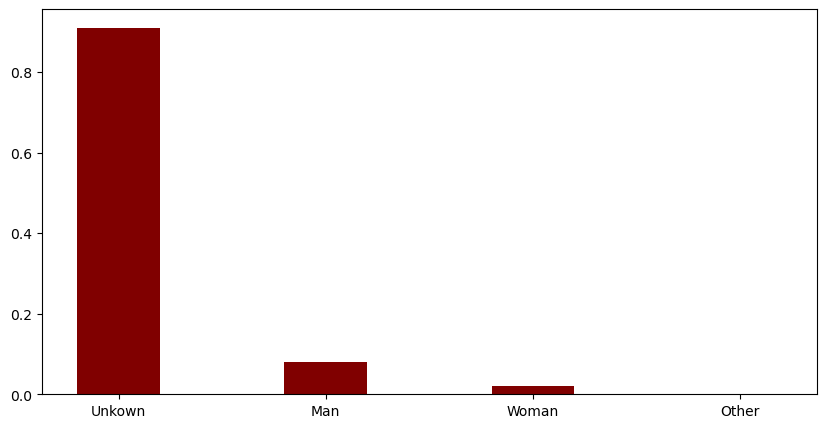

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
 
  
# creating the dataset
data = {'Unkown':0.91, 'Man':0.08, 'Woman':0.02, 
        'Other':0}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)
plt.show()

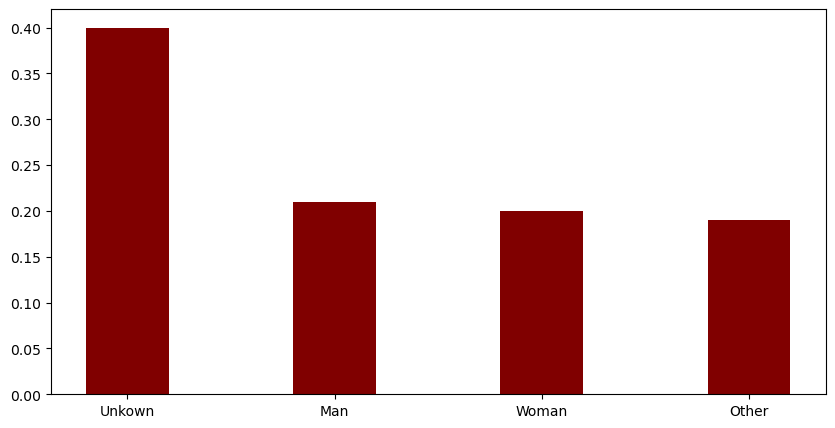

In [10]:
import numpy as np
import matplotlib.pyplot as plt 
 
  
# creating the dataset
data = {'Unkown':0.4, 'Man':0.21, 'Woman':0.20, 
        'Other':0.19}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)
plt.show()

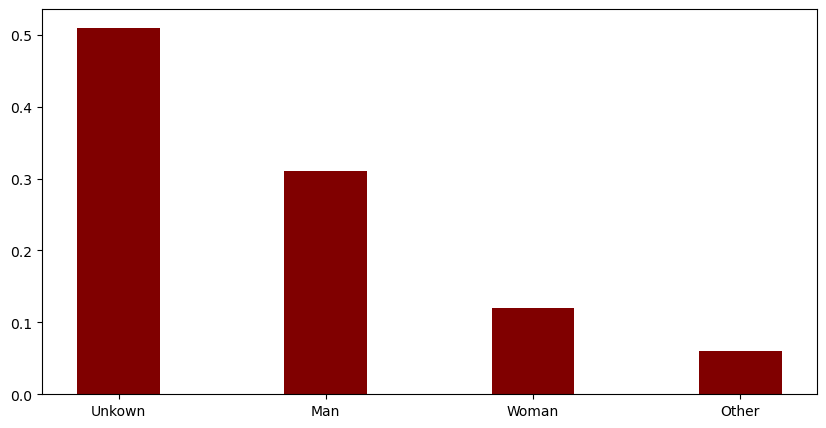

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
 
  
# creating the dataset
data = {'Unkown':0.51, 'Man':0.31, 'Woman':0.12, 
        'Other':0.06}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)
plt.show()